In [1]:
pip install pandas numpy scikit-learn nltk

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pandas in c:\users\bibek\appdata\local\programs\python\python311\lib\site-packages (2.2.0)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 885.6 kB/s eta 0:00:02
   -------------------- ------------------- 0.8/1.5 MB 907.1 kB/s eta 0:00:01
   --------------------------- ------------ 1.0/1.5 MB 988.0 kB/s eta 0:00:01
   ---------------------------------- ----- 1.3/1.5 MB 1.0 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.1 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)




[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
import re


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bibek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
data = pd.read_csv(r"C:\Users\bibek\OneDrive\Documents\hotel survey.csv")

print(data.head())



                     id             dateAdded           dateUpdated  \
0  AVwc252WIN2L1WUfpqLP  2016-10-30T21:42:42Z  2018-09-10T21:06:27Z   
1  AVwc252WIN2L1WUfpqLP  2016-10-30T21:42:42Z  2018-09-10T21:06:27Z   
2  AVwc252WIN2L1WUfpqLP  2016-10-30T21:42:42Z  2018-09-10T21:06:27Z   
3  AVwdOclqIN2L1WUfti38  2015-11-28T19:19:35Z  2018-09-10T21:06:16Z   
4  AVwdOclqIN2L1WUfti38  2015-11-28T19:19:35Z  2018-09-10T21:06:16Z   

             address                                         categories  \
0  5921 Valencia Cir  Hotels,Hotels and motels,Hotel and motel reser...   
1  5921 Valencia Cir  Hotels,Hotels and motels,Hotel and motel reser...   
2  5921 Valencia Cir  Hotels,Hotels and motels,Hotel and motel reser...   
3     7520 Teague Rd  Hotels,Hotels and motels,Travel agencies and b...   
4     7520 Teague Rd  Hotels,Hotels and motels,Travel agencies and b...   

               primaryCategories             city country  \
0  Accommodation & Food Services  Rancho Santa Fe      US   


In [17]:
import nltk, re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

pattern = re.compile(r'[^a-zA-Z]')

def clean_text(text):
    text = pattern.sub(' ', str(text)).lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['Clean_Review'] = data['reviews.text'].apply(clean_text)

print(data[['reviews.text', 'Clean_Review']].head())



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bibek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                        reviews.text  \
0  Our experience at Rancho Valencia was absolute...   
1  Amazing place. Everyone was extremely warm and...   
2  We booked a 3 night stay at Rancho Valencia to...   
3  Currently in bed writing this for the past hr ...   
4  I live in Md and the Aloft is my Home away fro...   

                                        Clean_Review  
0  experience rancho valencia absolutely perfect ...  
1  amazing place everyone extremely warm welcomin...  
2  booked night stay rancho valencia play tennis ...  
3  currently bed writing past hr dogs barking squ...  
4  live md aloft home away home stayed night staf...  


In [18]:
print(data[['reviews.text', 'Clean_Review']].head(10))

                                        reviews.text  \
0  Our experience at Rancho Valencia was absolute...   
1  Amazing place. Everyone was extremely warm and...   
2  We booked a 3 night stay at Rancho Valencia to...   
3  Currently in bed writing this for the past hr ...   
4  I live in Md and the Aloft is my Home away fro...   
5  I stayed here with my family for my daughters ...   
6  Beautiful rooms and the nicest people working ...   
7  We stayed here while visiting Maryland Live!. ...   
8  I travel a lot with my job, so I'm constantly ...   
9  In my line of work, I use meeting space in hot...   

                                        Clean_Review  
0  experience rancho valencia absolutely perfect ...  
1  amazing place everyone extremely warm welcomin...  
2  booked night stay rancho valencia play tennis ...  
3  currently bed writing past hr dogs barking squ...  
4  live md aloft home away home stayed night staf...  
5  stayed family daughters wedding accommodating ... 

In [19]:
# Convert ratings to sentiment labels
data['Sentiment'] = data['reviews.rating'].apply(lambda x: 'Positive' if x >= 4 else ('Negative' if x <= 2 else 'Neutral'))

# Keep only Positive and Negative for binary classification
data = data[data['Sentiment'] != 'Neutral']

# Count of each sentiment
print(data['Sentiment'].value_counts())


Sentiment
Positive    14917
Negative     2264
Name: count, dtype: int64


In [31]:
from sklearn.utils import resample

positive = data[data['Sentiment'] == 'Positive']
negative = data[data['Sentiment'] == 'Negative']

# Match the smaller class count
min_len = min(len(positive), len(negative))

positive_down = resample(positive, replace=False, n_samples=min_len, random_state=42)
negative_down = resample(negative, replace=False, n_samples=min_len, random_state=42)

balanced_data = pd.concat([positive_down, negative_down])
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_data['Sentiment'].value_counts())


Sentiment
Negative    2264
Positive    2264
Name: count, dtype: int64


In [33]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

balanced_data['Clean_Review'] = balanced_data['reviews.text'].apply(clean_text)


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9183222958057395
              precision    recall  f1-score   support

    Negative       0.91      0.93      0.92       453
    Positive       0.93      0.91      0.92       453

    accuracy                           0.92       906
   macro avg       0.92      0.92      0.92       906
weighted avg       0.92      0.92      0.92       906



In [36]:
import numpy as np

feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = model.coef_[0].argsort()

print("Top positive words:", feature_names[sorted_coef_index[-10:]])
print("Top negative words:", feature_names[sorted_coef_index[:10]])


Top positive words: ['helpful' 'good' 'excellent' 'wonderful' 'enjoyed' 'friendly' 'clean'
 'comfortable' 'nice' 'great']
Top negative words: ['dirty' 'old' 'sorry' 'worst' 'room' 'told' 'did' 'rude' 'smell' 'poor']


In [39]:
new_review = ["The hotel was worst and staff were bad"]
cleaned = [clean_text(new_review[0])]
vectorized = tfidf.transform(cleaned)
print(model.predict(vectorized))


['Negative']


In [41]:
print(data[['Sentiment', 'Clean_Review']].head(10))


  Sentiment                                       Clean_Review
0  Positive  experience rancho valencia absolutely perfect ...
1  Positive  amazing place everyone extremely warm welcomin...
2  Positive  booked night stay rancho valencia play tennis ...
3  Negative  currently bed writing past hr dogs barking squ...
4  Positive  live md aloft home away home stayed night staf...
5  Positive  stayed family daughters wedding accommodating ...
6  Positive  beautiful rooms nicest people working front de...
7  Positive  stayed visiting maryland live cute hotel great...
8  Positive  travel lot job constantly staying hotels co wo...
9  Positive  line work use meeting space hotels often years...


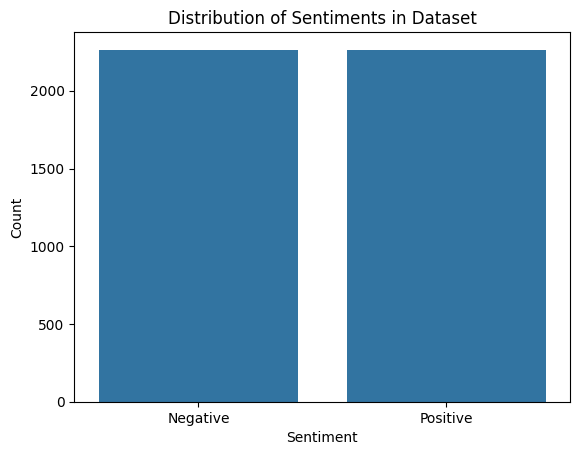

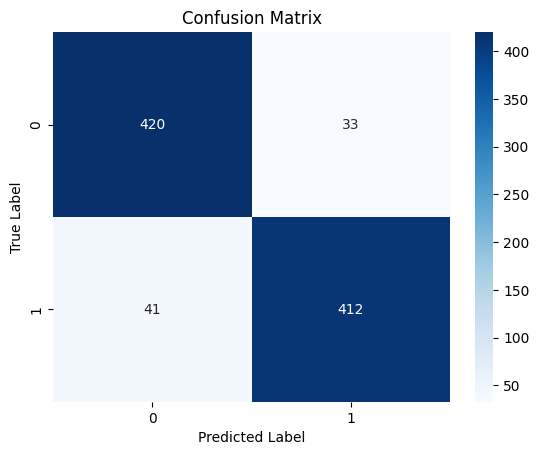

Positive text length: 4356181
Negative text length: 849227


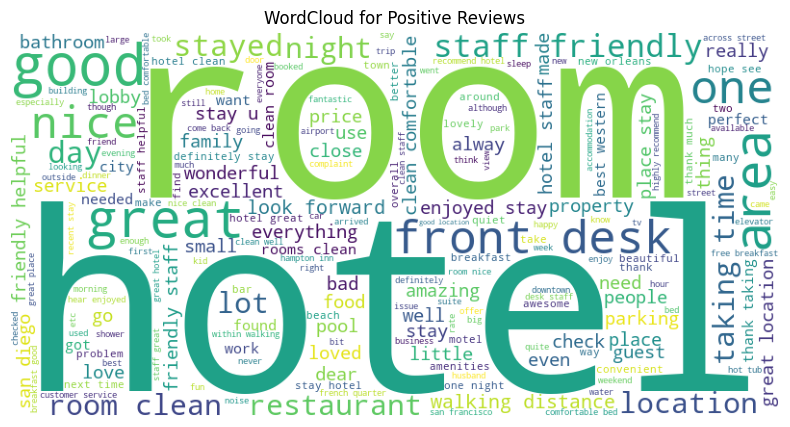

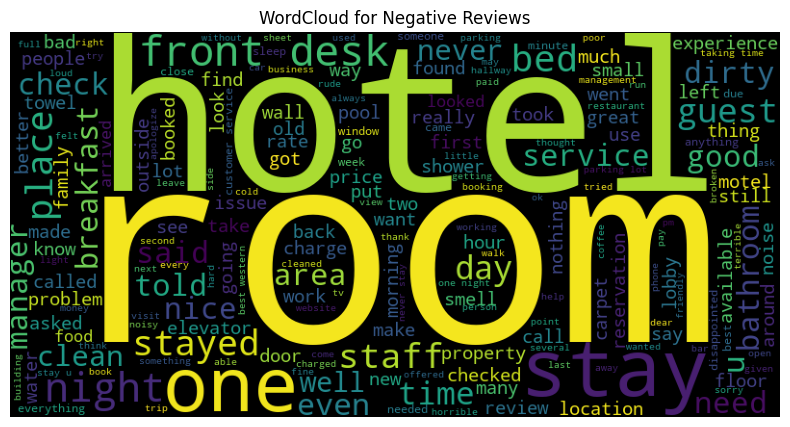

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1️⃣ Sentiment Distribution
sns.countplot(x=y)
plt.title("Distribution of Sentiments in Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# 2️⃣ Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 3️⃣ Word Clouds for Positive & Negative Reviews
positive_text = " ".join(data[data['Sentiment']=='positive']['Clean_Review'])
negative_text = " ".join(data[data['Sentiment']=='negative']['Clean_Review'])
print("Positive text length:", len(positive_text))
print("Negative text length:", len(negative_text))

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.title("WordCloud for Positive Reviews")
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.title("WordCloud for Negative Reviews")
plt.show()


In [45]:
pip install flask joblib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
import joblib

joblib.dump(model, "sentiment_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [47]:
import os
os.getcwd()


'C:\\Users\\bibek'